In [1]:
 ### Prepare module structure ###

import sys
sys.path.append("../")

In [37]:
### IMPORT ###

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import time
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

from util import *
from data import *
import models

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2
print(torch.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.0.0


In [3]:
### Check device ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    # TODO: Change to CPU used!
    device = torch.device('cuda:1')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


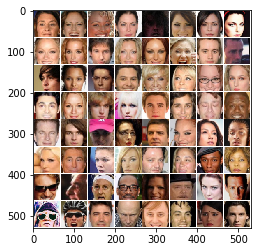

torch.Size([64, 3, 64, 64])


In [30]:
### LOAD DATA ###

dataloader, imsize = load(name='CelebA64', path='/home/shared/phase-retrieval/data/CelebA64.h5', batch_size=64)

sample = next(iter(dataloader['train']))
plot_grid(sample, figsize=(4, 4))
print(sample.shape)
sample_ft =  torch.rfft(sample, 2, onesided=False)
sample_magnitudes = torch.sqrt(torch.sum(sample_ft**2, -1))

In [64]:
# Function to compute test images

def add_noise(magn, device, alpha=1):
    magn_sq = magn**2
    noise = torch.randn(*magn.shape, device=device)
    # scale noise by standard deviation
    # we want to have variance Diag(alpha**2*magn_sq) for vec(noise)
    noisy_magn = magn_sq + noise * magn * alpha
    return torch.sqrt(noisy_magn + 1e-16)

def calc_mags(x):
    ft =  torch.rfft(x, 2, onesided=False)
    mags = torch.sqrt(torch.sum(ft**2, -1) + 1e-16)
    return mags

def test_generator(model, device, testloader, alpha):
    # put model to eval mode
    model = model.to(device=device)
    model.eval()

    # move test images to device and reduce to magnitude information in fourier space
    test_images = []
    outputs = []
    
    for data in testloader:
        z = torch.randn(*data.shape).to(device)
        data = data.to(device=device)
        magn = add_noise(calc_mags(data), device, alpha)
        net_input = torch.cat([z, magn], dim=1)
        ouput = model(net_input)

        test_images.append(data.cpu().numpy())
        outputs.append(ouput.cpu().detach().numpy())
    
    return np.concatenate(test_images), np.concatenate(outputs)

In [65]:
test_sample = next(iter(dataloader['test'])).to(device)

magn = calc_mags(test_sample)
magn_noise = add_noise(magn, device, alpha=1.0)

print(magn.max())
print(magn_noise.max())

tensor(-4.2318, device='cuda:1')
tensor(3685.9922, device='cuda:1')
tensor(nan, device='cuda:1')


In [6]:
### LOAD MODEL ####

gen = models.ConvNet(imsize=(6, 64, 64), outsize=imsize, s=64)
disc = models.ConvDiscriminator(imsize=(6, 64, 64), s=64)

# TODO: map storage location to correct GPU!
gen.load_state_dict(torch.load("../cache/models/cGAN_CelebA/ConvGenerator64CelebA_7_0.014.sd", map_location={'cuda:1': device.__str__()}));
disc.load_state_dict(torch.load("../cache/models/cGAN_CelebA/ConvDiscriminator64CelebA_7_0.014.sd", map_location={'cuda:1': device.__str__()}));

Version 0.6
Additional padding to fit 2 exp: (0, 0)
Kern size: 4096


In [23]:
# Calculate test predictions #

alpha = 1.0

test_images, test_outputs = test_generator(gen, device, dataloader['test'], alpha)
print(test_images.shape)

/home/alobe101/.local/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


(19963, 3, 64, 64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


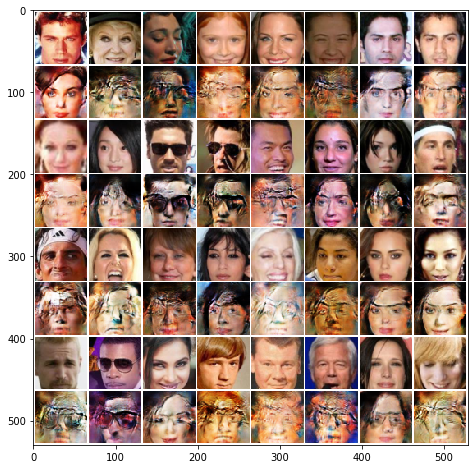

In [25]:
# Plot test predictions #

to_plot = np.stack([test_images[:32].reshape(4, 8*3, 64, 64), 
                    test_outputs[:32].reshape(4, 8*3, 64, 64)], axis=1).reshape(-1, 3, 64, 64)
           
plot_grid(torch.Tensor(to_plot), figsize=(8,8), file="../out/cgan/celeba/ConvGenerator64CelebA_Noise_1.0.png")

In [24]:
# Benchmark test predictions #

benchmark(pred=test_outputs[:1024], true=test_images[:1024], check=["mse", "mae", "ssim", "magn", "imcon"])

Signal error:
  MSE: 0.038502747186612396, std: 0.017371559658112466
  MAE: 0.1447834614373278, std: 0.03226824355142934
  SSIM: 0.3789015876077687, std: 0.10602365667389295

Magnitude error:
  MSE Magnitude: 49.77314177864625, std: 20.45074921093493

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

Markdown table values:
 0.03850 | 0.1448 | 0.3789 | 49.77 |


## Evaluation for different cGAN models (random z and 1024 samples)

| alpha |  MSE | MAE | SSIM | MSE Magn |
| --- | --- | --- | --- | --- |
| 0.0 |
| 0.01 |
| 0.1 |
| 1.0 | 

In [58]:
# Latent z optimization

def genopt(sample_magn, gen, device, steps=5000, lr=1.0):

    gen.to(device)
    gen.eval()

    z = torch.randn((sample_magn.shape), requires_grad=True, device=device)    
    optimizer = optim.Adam([z], lr=lr)
    
    losses = []
    last_out = gen(torch.cat([z, sample_magn], dim=1))
    
    with tqdm_notebook(total=steps) as progress_bar:
        for i in range(steps):
            magn = calc_mags(last_out)

            mse_all = torch.mean((magn - sample_magn) ** 2, dim=(1, 2, 3))
            loss = torch.sum(mse_all)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            last_out = gen(torch.cat([z, sample_magn], dim=1))

            losses.append(loss.item())
            
            progress_bar.set_postfix(loss=np.mean(losses[-100:]))
            progress_bar.update(1)
    
    return last_out.detach(), losses, mse_all

tensor(nan, device='cuda:1')


/home/alobe101/.local/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))



Batch 1/1 finished


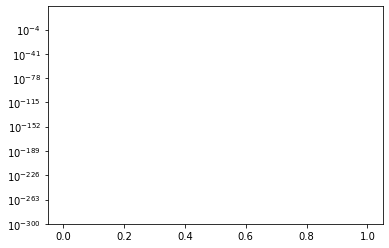

In [59]:
### Latent z optimization ###

num_batches = 1 # 16
batch_size = 64
steps = 1 # 5000
alpha = 1.0
lr = 1.0

###

out_original = np.zeros((batch_size * num_batches, *imsize))
out_results = np.zeros((batch_size * num_batches, *imsize))
mse_all = np.full((batch_size * num_batches), np.inf)

for batch_i, batch in enumerate(dataloader['test']):
    test_sample = batch.to(device)
    test_magn_noise = add_noise(calc_mags(test_sample), device, alpha)
    
    out_original[batch_size * batch_i : batch_size * batch_i + batch_size] = test_sample.cpu().numpy()

    cur_out_results, cur_loss, cur_mse_all = genopt(sample_magn=test_magn_noise, gen=gen,
                                                    device=device, steps=steps, lr=lr)
    cur_out_results = cur_out_results.cpu().numpy()
    
    out_results[batch_size * batch_i : batch_size * batch_i + batch_size] = cur_out_results
    mse_all[batch_size * batch_i : batch_size * batch_i + batch_size] = cur_mse_all.detach().cpu().numpy()

    print("Batch {0}/{1} finished".format(batch_i + 1, num_batches))
    if batch_i + 1 >= num_batches:
        break

plt.semilogy(cur_loss)
plt.show()

In [41]:
### CACHE RESULTS ###

import pickle
pickle.dump(out_original, open("/home/shared/phase-retrieval/test/cGAN_CelebA/cgan_noise_1.0_original.p", "wb"))
pickle.dump(out_results, open("/home/shared/phase-retrieval/test/cGAN_CelebA/cgan_noise_1.0.p", "wb"))

In [42]:
### LOAD RESULTS ###
import pickle

out_original = pickle.load(open("/home/shared/phase-retrieval/test/cGAN_CelebA/cgan_noise_1.0_original.p", "rb"))
out_results = pickle.load(open("/home/shared/phase-retrieval/test/cGAN_CelebA/cgan_noise_1.0.p", "rb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Output under minimized magnitude distance:


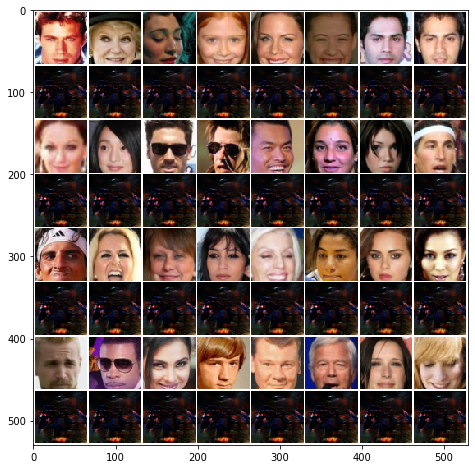

In [67]:
print("Output under minimized magnitude distance:")
to_plot = np.stack([out_original[:32].reshape(4, 8*3, 64, 64),
                    out_results[:32].reshape(4, 8*3, 64, 64)], axis=1).reshape(-1, 3, 64, 64)
plot_grid(to_plot, figsize=(8, 8), file="../out/cgan/celeba/ConvGenerator64CelebA_Noise_1.0_10000latentSteps.png")


In [66]:
# Benchmark test predictions #

benchmark(pred=out_results, true=out_original, check=["mse", "mae", "ssim", "magn", "imcon"])

Signal error:
  MSE: 0.2212439124920928, std: 0.10335121905986254
  MAE: 0.3909979212851778, std: 0.11461849231068502
  SSIM: 0.10552478812642584, std: 0.04303458600108501

Magnitude error:
  MSE Magnitude: 791.6611199833756, std: 422.79832417371057

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 0.98] - should be in [0, 1]

Markdown table values:
 0.2212 | 0.3910 | 0.1055 | 791.7 |


## Evaluation for different z optimizations (64 samples)

| alpha | iterations | lr | MSE | MAE | SSIM | MSE Magnitude
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 0.0 | 1000 | 1.0
| 0.01 |
| 0.1 |
| 1.0 | 


## Final Evaluation (1024 samples)

| alpha | iterations | lr | MSE | MAE | SSIM | MSE Magnitude
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 0.0 | 1000 | 1.0
| 0.01 |
| 0.1 |
| 1.0 | 